# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Imports</p>

In [1]:
import re
import torch
import argparse
import numpy as np
import transformers
import torch.nn.functional as F
import itertools
import collections
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer
from torch.optim.lr_scheduler import CosineAnnealingLR
import nltk
from sklearn.metrics import f1_score
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [3]:
PAD_TOKEN = '[PAD]'
UNK_TOKEN = '[UNK]'

auto_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Helper Functions</p>

In [4]:
def cuda(args, tensor):
    """
    Places tensor on CUDA device (by default, uses cuda:0).
    
    Returns:
        Tensor on CUDA device.
    """
    if args.use_gpu and torch:
        return tensor.cuda()
    else:
        return tensor

def unpack(tensor):
    """
    Unpacks a tensor into a Python list.

    Args:
        tensor: PyTorch tensor.

    Returns:
        Python list with tensor contents.
    """
    if tensor.requires_grad:
        tensor = tensor.detach()
    return tensor.cpu().numpy().tolist()

def load_embeddings(path):
    """
    Loads GloVe-style embeddings into memory.
    Args:
        path: Embedding path, e.g. "glove/glove.6B.300d.txt".

    Returns:
        Dictionary mapping words (strings) to vectors (list of floats).
    """
    embedding_map = {}
    with open(path, 'r', encoding="utf-8") as f:
        for line in f:
            try:
                pieces = line.rstrip().split()
                word = pieces[0].lower()  # Normalize to lowercase
                embedding_map[word] = [float(weight) for weight in pieces[1:]]
                
                # Also store lemma if different
                lemma = lemmatizer.lemmatize(word)
                if lemma != word and lemma not in embedding_map:
                    embedding_map[lemma] = [float(weight) for weight in pieces[1:]]
            except:
                pass
    return embedding_map

def embed_batch(embedding_map, embedding_layer, batch_token_ids, idx2word, embed_dim):
    """
    Iteratively converts a batch of token id sequences into their embeddings.

    Args:
        embedding_map (dict): Mapping from to embedding vectors.
        batch_token_ids (List[List[int]]): Batch where each element is a list of token ids.
        idx2word (dict): Mapping from token ID (int) to the corresponding word (str)
        embed_dim (int): The dimensionality of the embeddings.
    
    Returns:
        Numpy array of shape (batch_size, seq_len, embed_dim) containing the embeddings.
    """
    batch_embeddings = []
    
    for token_ids in batch_token_ids:
        sequence_embeddings = []
        for token_id in token_ids:
            # Retrieve the corresponding word for the token id.
            token = idx2word.get(token_id.item(), None)
            # print("Token", token_id.item(), token)
            if token is None and token not in embedding_map:
                token_embedding = np.zeros(embed_dim)
            else:
                try:
                    token_tensor = torch.tensor([token_id.item()], device=device)
                    token_embedding = embedding_layer(token_tensor).squeeze(0).cpu().detach().numpy()
                except Exception as e:
                    print(f"Token ID {token_id} caused error: {e}")
                    token_embedding = np.zeros(embed_dim)

            sequence_embeddings.append(token_embedding)
        batch_embeddings.append(sequence_embeddings)
    return np.array(batch_embeddings)

def co_attention(context_embedding, question_embedding, conv=True):
    """
    Co-attention mechanism that computes attention between context and question encodings.
    If `convolution=True`, applies local smoothing to the affinity matrix.

    Args:
        context_embedding (Tensor): (B, context_len, d)
        question_embedding (Tensor): (B, question_len, d)
        convolution (bool): whether to apply convolution-based smoothing.

    Returns:
        CP (Tensor): passage attention context
        E_Out (Tensor): final encoder output
    """
    # Step 1: Affinity matrix A ∈ (B, context_len, question_len)
    A = torch.bmm(context_embedding, question_embedding.transpose(1, 2))
    # print("context_embedding = ", context_embedding[0])
    # print("question_embedding = ", question_embedding[0])
    
    # print("context_embedding:", context_embedding)
    # print("question_embedding:", question_embedding)
    # print("Affinity range:", A.min().item(), A.max().item())

    # Apply learned smoothing
    if conv:
        A = conv_co_attention(A)

    # Step 2: Passage-to-question attention (row-wise)
    A_P = F.softmax(A, dim=2)

    # Step 3: Question-to-passage attention (column-wise)
    A_Q = F.softmax(A.transpose(1, 2), dim=2)

    # Step 4: Passage attention context: CP = H^P × A^Q
    # print("Context Embedding Shape", context_embedding.shape)
    # print("Question Embedding Shape", question_embedding.shape)
    # print("A_Q Shape", A_Q.shape)
    CP = torch.bmm(A_Q, context_embedding)
    # print("CP Shape", CP.shape)  # (B, Lq, d)

    # Step 5: Encoder output: concat(H^P, [H^Q; CP] × A^P)
    # QC = torch.cat([question_embedding, CP], dim=1)
    QC_1 = torch.bmm(A_P, question_embedding)  # (B, Lq, d)
    # print("QC_1 Shape", QC_1.shape)

    QC_2 = torch.bmm(A_P, CP)  # (B, Lq, d)
    # print("QC_2 Shape", QC_2.shape)

    # add & norm
    norm_1 = nn.LayerNorm(QC_1.shape[-1]).to(QC_1.device)
    QC = norm_1(QC_1 + QC_2)  # (B, Lq, d)

    # QC = torch.cat([QC_1, QC_2], dim=1) # (B, Lq, 2d)
    # QC = torch.cat([QC_1, QC_2], dim=-1)  # (B, Lq, 2d)
    # print("QC Shape", QC.shape)

    # Final encoder output
    # E_Out = torch.cat([context_embedding, QC], dim=2)
    E_Out = torch.cat([context_embedding, QC], dim=-1)  # (B, Lq, 3d)
    E_Out = nn.LayerNorm(E_Out.shape[-1]).to(E_Out.device)(E_Out)
    E_Out = torch.tanh(E_Out)  # Apply non-linearity

    # project to original dimension
    E_Out = nn.Linear(E_Out.shape[-1], context_embedding.shape[-1]).to(E_Out.device)(E_Out)
    # print("E_Out Shape", E_Out.shape)

    return CP, E_Out

def create_gaussian_kernel(kernel_width, device, sigma=1.0):
    """Creates a 1D Gaussian kernel."""
    x = torch.arange(-kernel_width//2 + 1, kernel_width//2 + 1, dtype=torch.float, device=device)
    kernel = torch.exp(-x**2 / (2*sigma**2))
    kernel /= kernel.sum()  # Normalize to sum to 1
    return kernel.view(1, 1, -1)

def conv_co_attention(A, kernel_width=11):
    """
    Enhanced convolution to shift attention to neighboring words.
    Applies 1D convolution along context dimension per question word.
    """
    B, Lp, Lq = A.shape
    # Permute A for per-question-word processing: (B, Lq, Lp) -> (B*Lq, 1, Lp)
    A_reshaped = A.permute(0, 2, 1).reshape(-1, 1, Lp)
    
    # Create Gaussian kernel with odd kernel width (e.g., 11)
    kernel = create_gaussian_kernel(kernel_width, A.device, sigma=1.0)
    
    # Use symmetric padding that keeps the sequence length unchanged.
    padded_length = (kernel_width - 1) // 2
    smoothed_A = F.conv1d(A_reshaped, kernel, padding=padded_length)
    
    # Reshape back: current shape is (B*Lq, 1, Lp) --> (B, Lq, Lp) then permute to (B, Lp, Lq)
    smoothed_A = smoothed_A.view(B, Lq, Lp).permute(0, 2, 1)
    A_adjusted = A + smoothed_A  # Enhance original scores with neighbor context
    return F.softmax(A_adjusted, dim=-1)

def tokenize_with_bert(text):
    # Tokenize the text and request offset mappings.
    encoding = auto_tokenizer(
        text,
        return_offsets_mapping=True,
        add_special_tokens=False  # Disable adding special tokens to mimic simple whitespace tokenization.
    )
    
    # Retrieve the tokens.
    tokens = auto_tokenizer.convert_ids_to_tokens(encoding['input_ids'])
    
    # Retrieve the spans from the offset mapping.
    spans = encoding['offset_mapping']
    return tokens, spans
    
def create_embedding_matrix(vocab, embedding_map, embedding_dim=300, scale=0.6):
    """Initialize embedding matrix with:
    - GloVe vectors for known words
    - Random vectors for UNK tokens
    - Zero vector for padding
    """
    # Initialize with random normal distribution (match GloVe scale)
    embedding_matrix = np.random.normal(
        scale=scale, 
        size=(len(vocab), embedding_dim)
    )
    
    # Handle special tokens
    embedding_matrix[vocab.encoding[PAD_TOKEN]] = np.zeros(embedding_dim)
    unk_idx = vocab.encoding[UNK_TOKEN]
    embedding_matrix[unk_idx] = np.random.normal(scale=scale, size=embedding_dim)
    
    for word, idx in vocab.encoding.items():
        if word in [PAD_TOKEN, UNK_TOKEN]:
            continue
            
        # Try direct match
        if word in embedding_map:
            embedding_matrix[idx] = embedding_map[word]
            continue
            
        # Try lemma
        lemma = lemmatizer.lemmatize(word)
        if lemma in embedding_map:
            embedding_matrix[idx] = embedding_map[lemma]
            continue
            
        # Try lowercase lemma
        lower_lemma = lemmatizer.lemmatize(word.lower())
        if lower_lemma in embedding_map:
            embedding_matrix[idx] = embedding_map[lower_lemma]

    return torch.tensor(embedding_matrix, dtype=torch.float32)

def enforce_position_constraints(end_logits, start_positions):
    """
    Mask end_logits positions before the corresponding start_positions.
    """
    batch_size, seq_len = end_logits.size()
    positions = torch.arange(seq_len, device=end_logits.device).unsqueeze(0).expand(batch_size, seq_len)
    mask = positions < start_positions.unsqueeze(1)
    return end_logits.masked_fill(mask, float('-inf'))

def simple_tokenizer(text):
    tokens = re.findall(r"\w+(?:[-']\w+)*", text.lower())
    spans = []
    start = 0
    for token in tokens:
        start = text.lower().find(token, start)
        spans.append((start, start + len(token)))
        start += len(token)
    return tokens, spans

# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Data Handling</p>

In [5]:
########################################################################################################
#                                                                                                      #
#                                                Vocabulary                                            #
#                                                                                                      #
########################################################################################################
class Vocabulary:
    """
    Creates mappings for words → indices and indices → words.
    """
    def __init__(self, samples, vocab_size):
        self.samples = samples
        self.vocab_size = vocab_size
        self.words = self._initialize(samples, vocab_size)
        self.encoding = {word: idx for idx, word in enumerate(self.words)}
        self.decoding = {idx: word for idx, word in enumerate(self.words)}

    def _initialize(self, samples, vocab_size):
        """Build vocabulary with lemma support"""
        embedding_map = load_embeddings("/kaggle/input/glove/other/default/1/glove.6B.300d.txt")
        vocab_counts = collections.defaultdict(int)
        
        for _, row in samples.iterrows():
            # Get base tokens
            tokens = re.findall(r"\w+(?:[-']\w+)*", row['context'].lower()) + \
                     re.findall(r"\w+(?:[-']\w+)*", row['question'].lower())
            
            # Count both original and lemma forms
            for token in tokens:
                vocab_counts[token] += 1
                lemma = lemmatizer.lemmatize(token)
                if lemma != token:
                    vocab_counts[lemma] += 0.5  # Partial count for lemmas
        
        # Sort by combined frequency
        sorted_words = sorted(vocab_counts.items(), 
                            key=lambda x: (-x[1], x[0]))[:vocab_size-2]
        
        return [PAD_TOKEN, UNK_TOKEN] + [w[0] for w in sorted_words]
        
    def __len__(self):
        return len(self.words)

########################################################################################################
#                                                                                                      #
#                                                Tokenizer                                             #
#                                                                                                      #
########################################################################################################
class Tokenizer:
    """
    Converts lists of words to indices and vice versa.
    """
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.pad_token_id = vocabulary.encoding[PAD_TOKEN]
        self.unk_token_id = vocabulary.encoding[UNK_TOKEN]

    def convert_tokens_to_ids(self, tokens):
        return [self.vocabulary.encoding.get(token.lower(), self.unk_token_id) for token in tokens]

    def convert_ids_to_tokens(self, token_ids):
        return [self.vocabulary.decoding.get(token_id, UNK_TOKEN) for token_id in token_ids]

########################################################################################################
#                                                                                                      #
#                                                QADataset                                             #
#                                                                                                      #
########################################################################################################
class QADataset(Dataset):
    """
    Data generator for a QA task; the JSON file should contain character-level answer indices.
    """
    def __init__(self, path):
        # Load JSON-lines file; each line is a JSON object.
        self.samples = pd.read_json(path, lines=True)
        self.tokenizer = None
        # Default pad token id; updated after tokenizer registration.
        self.pad_token_id = 0

    def _collate_batch(self, batch):
        batch = [sample for sample in batch if sample is not None]
        if len(batch) == 0:
            return None  # All samples failed
    
        max_context_len = max(sample['context'].size(0) for sample in batch)
        max_question_len = max(sample['question'].size(0) for sample in batch)
        
        contexts = torch.stack([
            torch.cat([
                sample['context'],
                torch.full((max_context_len - sample['context'].size(0),), self.pad_token_id, dtype=torch.long)
            ]) for sample in batch
        ])
    
        questions = torch.stack([
            torch.cat([
                sample['question'],
                torch.full((max_question_len - sample['question'].size(0),), self.pad_token_id, dtype=torch.long)
            ]) for sample in batch
        ])
    
        answer_starts = torch.stack([sample['answer_start'] for sample in batch])
        answer_ends = torch.stack([sample['answer_end'] for sample in batch])
    
        return {
            'context': contexts,
            'question': questions,
            'answer_start': answer_starts,
            'answer_end': answer_ends
        }

    def register_tokenizer(self, tokenizer):
        """
        Registers a Tokenizer instance and updates pad token id.
        """
        self.tokenizer = tokenizer
        self.pad_token_id = tokenizer.pad_token_id

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples.iloc[idx]
        context_str = sample['context']
        question_str = sample['question']
        answers = sample['answers']
    
        # Tokenize context and question
        # context_tokens, context_spans = tokenize_with_bert(context_str)
        # question_tokens, _ = tokenize_with_bert(question_str)

        context_tokens, context_spans = simple_tokenizer(context_str)
        question_tokens, _ = simple_tokenizer(question_str)
    
        context_indices = self.tokenizer.convert_tokens_to_ids(context_tokens)
        question_indices = self.tokenizer.convert_tokens_to_ids(question_tokens)
    
        # Character-level answer span
        try:
            char_start = answers['answer_start'][0]
            answer_text = answers['text'][0].strip()
            char_end = char_start + len(answer_text)
        except Exception as e:
            return None  # Invalid or empty answer
    
        # Convert character span to token indices
        token_start, token_end = None, None
        for i, (s, e) in enumerate(context_spans):
            if s <= char_start < e:
                token_start = i
            if s < char_end <= e:
                token_end = i
            if token_start is not None and token_end is not None:
                break
    
        if token_start is None or token_end is None:
            return None  # Skip misaligned sample
    
        return {
            'context': torch.tensor(context_indices, dtype=torch.long),
            'question': torch.tensor(question_indices, dtype=torch.long),
            'answer_start': torch.tensor(token_start, dtype=torch.long),
            'answer_end': torch.tensor(token_end, dtype=torch.long),
        }


# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Model Architecture</p>

In [6]:
########################################################################################################
#                                                                                                      #
#                                       Transformer Blocks                                             #
#                                                                                                      #
########################################################################################################
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention mechanism for the Transformer model.
    This class implements the multi-head attention mechanism as described in the paper "Attention is All You Need".
    
    Args:
        d_model (Tensor): Dimensionality of the input
        num_heads (int): The number of attention heads to split the input into it.

    Returns:
        context: (Tensor): The context vector after applying attention.
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()

        # Ensure that the model dimension is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, query, key, value, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        # Apply softmax to get attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)

        # Calculate the context vector as a weighted sum of values
        context = torch.matmul(attn_weights, value)

        return context

    def split_heads(self, x):
        """
        Split the input tensor into multiple heads for multi-head attention.
        """
        # Reshape the input to have num_heads for multi-head attention.
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape.
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, query, key, value, mask=None):
        # Apply linear transformations and split heads.
        query = self.split_heads(self.W_q(query))  # (batch_size, num_heads, seq_length, d_k)
        key = self.split_heads(self.W_k(key))  # (batch_size, num_heads, seq_length, d_k)
        value = self.split_heads(self.W_v(value))  # (batch_size, num_heads, seq_length, d_k)

        # Perform scaled dot-product attention
        context = self.scaled_dot_product_attention(query, key, value, mask)  # (batch_size, num_heads, seq_length, d_k)

        # Combine the heads and apply output transformation.
        output = self.W_o(self.combine_heads(context))

        return output
    
class PositionWiseFeedForward(nn.Module):
    """
    Position-wise feed-forward netowrk consists of two linear transformations with a ReLU activation in between.
    In the context of transformer models, this feed-forward network is applied to each position separately and identically.
    It helps in transforming the features learned by the attention mechanisms within the transformer, 
    acting as an additional processing step for the attention outputs.
    """
    def __init__(self, d_model, d_ff, dropout_prob=0.1):
        """
        Args:
            d_model (int): Dimensionality of the input.
            d_ff (int): Dimensionality of the feed-forward layer.
            dropout_prob (float): Dropout probability for regularization.
        """
        super(PositionWiseFeedForward, self).__init__()

        # Feed-forward network with two linear layers and ReLU activation.
        self.fc1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass through the feed-forward network.
        
        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, d_model).

        Returns:
            out (Tensor): Output tensor of the same shape as input.
        """
        # Apply the first linear transformation, activation, and dropout.
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Apply the second linear transformation.
        out = self.fc2(x)

        return out
    
class PositionalEncoding(nn.Module):
    """
    Positional encoding is used to inject information about the relative or absolute position of the tokens in the sequence.
    It helps the model understand the order of the tokens, as the transformer architecture does not inherently capture this information.
    """
    def __init__(self, d_model, max_seq_length=5000):
        """
        Args:
            d_model (int): Dimensionality of the model.
            max_seq_length (int): Maximum length of the input sequences.
        """
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model) # A tensor filled with zeros, which will be populated with positional encodings.
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1) # A tensor containing the position indices for each positon in the sequence.
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)) # A term used to scale the position indices in a spcific way.
        
        # Apply the sine function to the even indices.
        pe[:, 0::2] = torch.sin(position * div_term)

        # Apply the cosine the function to the odd indices.
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register pe as a buffer, which means it will be part of the module's state but will not be considered a trainable parameter.
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Add positional encoding to input tensor.
        return x + self.pe[:, :x.size(1)]

class TransformerEncoder(nn.Module):
    """
    Transformer Encoder block that consists of multi-head self-attention and feed-forward layers.
    The encoder processes the input sequences and generates a contextual representation of the input.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout_prob=0.3):
        """
        Transformer Encoder block that consists of multi-head self-attention and feed-forward layers.

        Args:
            d_model (int): Dimensionality of the model.
            num_heads (int): Number of attention heads.
            d_ff (int): Dimensionality of the feed-forward layer.
            dropout_prob (float): Dropout probability for regularization.
        """
        super(TransformerEncoder, self).__init__()

        self.self_attn = MultiHeadAttention(d_model, num_heads) # multi-head attention mechanism.
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout_prob) # position-wise feed-forward neural network.
        self.norm1 = nn.LayerNorm(d_model) # layer normalization, applied to smooth the layer's input.
        self.norm2 = nn.LayerNorm(d_model) # layer normalization, applied to smooth the layer's input.
        self.dropout = nn.Dropout(dropout_prob) # dropout layer, used to prevent overfitting by randomly setting some activatons to zero during training.
        
    def forward(self, x, mask):
        """
        Forward pass through the transformer encoder block.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, d_model).
            mask (Tensor): Mask tensor to prevent attention to certain positions.

        Returns:
            out (Tensor): Output tensor of the same shape as input.
        """
        # Apply multi-head self-attention
        attn_output = self.self_attn(x, x, x, mask)

        # Apply dropout and layer normalization.
        x = self.norm1(x + self.dropout(attn_output))

        # Apply feed-forward network
        ff_output = self.feed_forward(x)

        # Apply dropout and layer normalization.
        out = self.norm2(x + self.dropout(ff_output))

        return out

########################################################################################################
#                                                                                                      #
#                                   QATransformerBasedModel                                            #
#                                                                                                      #
########################################################################################################
class QATransformerBasedModel(nn.Module):
    def __init__(
        self, vocab, vocab_decoder, embedding_dim, d_ff,
        num_layers, num_heads, max_seq_length, dropout_prob=0.3
    ):
        super().__init__()

        self.vocab = vocab
        self.vocab_decoder = vocab_decoder
        self.dropout_prob = dropout_prob

        # Embedding map using pre-trained GloVe embeddings
        self.embedding_map = load_embeddings("/kaggle/input/glove/other/default/1/glove.6B.300d.txt")

        # Initialize Embedding layer
        self.embedding_layer = nn.Embedding(
            num_embeddings = len(vocab),
            embedding_dim = embedding_dim,
            padding_idx = vocab.encoding[PAD_TOKEN]
        )

        # Load pretrained weights
        embedding_matrix = create_embedding_matrix(vocab, self.embedding_map)
        self.embedding_layer.weight.data.copy_(embedding_matrix)

        # Freeze only GloVe vectors
        for i, word in enumerate(vocab.words):
            if word in self.embedding_map and word != UNK_TOKEN:
                self.embedding_layer.weight.requires_grad_(False)

        # Positional Encoding
        self.pos_encoding = PositionalEncoding(embedding_dim, max_seq_length)

        # Split layers into pre- and post-cross-attention
        self.post_encoders = nn.ModuleList([
            TransformerEncoder(embedding_dim, num_heads, d_ff, dropout_prob)
            for _ in range(num_layers)
        ])

        # Cross-Attention
        self.cross_attn = MultiHeadAttention(embedding_dim, num_heads)
        self.cross_attn_norm = nn.LayerNorm(embedding_dim, embedding_dim)
        self.cross_attn_dropout = nn.Dropout(dropout_prob)

        # Span Prediction Head (FFN)
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.ReLU(),
            nn.Linear(embedding_dim // 2, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, 2)
        )
        
        self.vocab = vocab

    def forward(self, context_ids, question_ids):
        # Embedding + Positional Encoding
        c = self.embedding_layer(context_ids)
        c = self.pos_encoding(c)
        q = self.embedding_layer(question_ids)
        q = self.pos_encoding(q)

        # Masks
        c_mask = (context_ids != self.vocab.encoding[PAD_TOKEN]).unsqueeze(1).unsqueeze(2)

        # 1) Cross-attention: context attends to question
        c = self.cross_attn(query=c, key=q, value=q, mask=None)
        c = self.cross_attn_dropout(c)
        c = self.cross_attn_norm(c)

        # 2) Pre-cross self-attention stacks
        for enc in self.post_encoders:
            c = enc(c, c_mask)

        # 4) Span prediction feed-forward head
        logits = self.classifier(c)
        start_logits, end_logits = logits.split(1, dim=-1)
        return start_logits.squeeze(-1), end_logits.squeeze(-1)


# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Model Training</p>

## Evaluation Functions

In [7]:
# Evaluation Functions
def compute_em(predicted, actual):
    return int(predicted.strip().lower() == actual.strip().lower())

def compute_f1(predicted, actual):
    pred_tokens = predicted.strip().lower().split()
    actual_tokens = actual.strip().lower().split()

    common = set(pred_tokens) & set(actual_tokens)
    if not common:
        return 0.0
    
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(actual_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    
    return f1

## Setting Data paths & Hyperparameters

In [8]:
import os
import math
from copy import deepcopy

# Kaggle dataset paths
MODEL_NAME = 'QATransformerBasedModel'  # or '# Kaggle dataset paths
TRAIN_PATH = '/kaggle/input/squad-v2/train.json'
VAL_PATH = '/kaggle/input/validation/validation.json'
WORKING_DIR = '/kaggle/working'
MODEL_DIR = os.path.join(WORKING_DIR, 'model')
OUT_DIR = os.path.join(WORKING_DIR, 'out')

# Hyperparameters
BATCH_SIZE = 16
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
EMBEDDING_DIM = 300
NUM_HEADS = 6
D_FF = 512
NUM_LAYERS = 2
DROPOUT = 0.1
MAX_CONTEXT_LEN = 400
MODEL_NAME = 'QATransformerBasedModel'

# Ensure directories exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Loading Dataset

In [10]:
# Load datasets
train_ds = QADataset(path=TRAIN_PATH)
val_ds = QADataset(path=VAL_PATH)

# Build vocab and tokenizer
vocab = Vocabulary(train_ds.samples, vocab_size=200000)
tokenizer = Tokenizer(vocab)
train_ds.tokenizer = tokenizer
val_ds.tokenizer = tokenizer

# Filter long contexts
def filter_len(df):
    return df[df['context'].map(len) <= MAX_CONTEXT_LEN].reset_index(drop=True)
    
train_ds.samples = filter_len(train_ds.samples)
val_ds.samples = filter_len(val_ds.samples)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=train_ds._collate_batch, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=val_ds._collate_batch, num_workers=2)


In [11]:
len(train_ds.samples)

17822

In [13]:
total_examples = len(train_ds.samples)
num_unique_contexts = train_ds.samples['context'].nunique()

print(f"Total examples:          {total_examples}")
print(f"Unique contexts count:   {num_unique_contexts}")

Total examples:          17822
Unique contexts count:   12533


## Model Training

In [14]:
def span_loss_no_mask(start_logits, end_logits, start_pos, end_pos):
    # 1) start loss over full distribution
    start_loss = F.cross_entropy(start_logits, start_pos)
    
    # 2) predicted start (detach so no grad through argmax)
    with torch.no_grad():
        s_pred = start_logits.argmax(dim=1)  # (B,)
    
    # 3) end loss over full distribution (unconstrained)
    end_loss = F.cross_entropy(end_logits, end_pos)
    
    return start_loss, end_loss, s_pred, end_logits

In [16]:
# Model
model = QATransformerBasedModel(
    vocab=vocab,
    vocab_decoder=vocab.decoding,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    d_ff=D_FF,
    num_layers=NUM_LAYERS,
    max_seq_length=MAX_CONTEXT_LEN,
    dropout_prob=DROPOUT
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=100,
    num_training_steps=NUM_EPOCHS * len(train_loader)
)

# Training loop
train_losses      = []
train_start_accs  = []
train_end_accs    = []
val_em_scores     = []
val_f1_scores     = []
val_start_f1s     = []
val_end_f1s       = []

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        if batch is None:
            continue
        
        ctx = batch['context'].to(device)
        qry = batch['question'].to(device)
        start_gt = batch['answer_start'].to(device)
        end_gt   = batch['answer_end'].to(device)

        # compute context lengths once
        PAD_ID = tokenizer.pad_token_id
        context_lengths = (ctx != PAD_ID).sum(dim=1)

        optimizer.zero_grad()
        s_logit, e_logit = model(ctx, qry)                            # (B, L)

        # use predicted start for masking end
        start_loss, end_loss, s_pred, e_logit_masked = span_loss_no_mask(
            s_logit, e_logit, start_gt, end_gt
        )

        s_pred = s_logit.argmax(dim=1)      # (B,)
        e_pred = e_logit_masked.argmax(dim=1)  # (B,)
        length_gt   = (end_gt - start_gt + 1).float()    # (B,)
        length_pred = (e_pred - s_pred + 1).float()      # (B,)
        length_diff = torch.abs(length_pred - length_gt) # (B,)
        length_loss = length_diff.mean()                 # scalar

        loss = 0.7 * start_loss + 0.3 * end_loss + 0.1 * length_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

        # track per-batch accuracies
        start_acc = (s_pred == start_gt).float().mean().item()
        e_pred = e_logit_masked.argmax(dim=1)
        end_acc   = (e_pred == end_gt).float().mean().item()

        train_start_accs.append(start_acc)
        train_end_accs.append(end_acc)

    avg_loss      = epoch_loss / len(train_loader)
    avg_start_acc = np.mean(train_start_accs) * 100
    avg_end_acc   = np.mean(train_end_accs)   * 100
    train_losses.append(avg_loss)

    print(f"Epoch {epoch}/{NUM_EPOCHS} — "
          f"Loss: {avg_loss:.4f} — "
          f"Start Acc per training set: {avg_start_acc:.2f}% — "
          f"End Acc per training set: {avg_end_acc:.2f}%")

    # Validation
    model.eval()

    all_start_preds = []
    all_start_gts   = []
    all_end_preds   = []
    all_end_gts     = []
    ems, f1s        = [], []

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            if batch is None:
                continue

            ctx      = batch['context'].to(device)
            qry      = batch['question'].to(device)
            start_gt = batch['answer_start'].to(device)
            end_gt   = batch['answer_end'].to(device)

            s_logit, e_logit = model(ctx, qry)
            e_logit = enforce_position_constraints(e_logit, start_gt)

            s_pred = s_logit.argmax(dim=1)
            e_pred = e_logit.argmax(dim=1)
            e_pred = torch.where(e_pred < s_pred, s_pred, e_pred)

            # collect for start/end F1
            all_start_preds.extend(s_pred.cpu().tolist())
            all_start_gts.extend(start_gt.cpu().tolist())
            all_end_preds.extend(e_pred.cpu().tolist())
            all_end_gts.extend(end_gt.cpu().tolist())

            # your existing EM/F1 computation for text spans
            for i in range(ctx.size(0)):
                sp, ep = s_pred[i].item(), e_pred[i].item()
                toks = tokenizer.convert_ids_to_tokens(ctx[i].cpu().tolist())
                pred_text = " ".join(toks[sp:ep+1]).strip()
        
                sample_idx = batch_idx * BATCH_SIZE + i
                gold_text  = val_ds.samples.iloc[sample_idx]['answers']['text'][0].strip()
        
                ems.append(compute_em(pred_text, gold_text))
                f1s.append(compute_f1(pred_text, gold_text))
                
    # compute span‐based EM/F1
    mean_em = np.mean(ems) * 100
    mean_f1 = np.mean(f1s) * 100

    # compute index‐based F1s
    start_index_f1 = f1_score(all_start_gts, all_start_preds, average='macro') * 100
    end_index_f1   = f1_score(all_end_gts,   all_end_preds,   average='macro') * 100

    val_em_scores.append(mean_em)
    val_f1_scores.append(mean_f1)
    val_start_f1s.append(start_index_f1)
    val_end_f1s.append(end_index_f1)

    print(
        f"Epoch {epoch} — "
        f"Start‑idx F1: {start_index_f1:.2f}% — "
        f"End‑idx F1: {end_index_f1:.2f}% — "
        f"EM: {mean_em:.2f}% — "
        f"Span‑F1: {mean_f1:.2f}%"
    )
    if epoch % 5 == 0:
        ckpt = os.path.join(MODEL_DIR, f"{MODEL_NAME}_ep{epoch}.pt")
        torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'vocab': vocab}, ckpt)
        print(f"Checkpoint saved: {ckpt}")

Epoch 1/30 — Loss: 3.8664 — Start Acc per training set: 11.81% — End Acc per training set: 11.26%
Epoch 1 — Start‑idx F1: 10.65% — End‑idx F1: 22.50% — EM: 5.66% — Span‑F1: 17.02%
Epoch 2/30 — Loss: 3.3135 — Start Acc per training set: 15.07% — End Acc per training set: 13.77%
Epoch 2 — Start‑idx F1: 10.82% — End‑idx F1: 23.01% — EM: 6.53% — Span‑F1: 17.47%
Epoch 3/30 — Loss: 3.1009 — Start Acc per training set: 17.28% — End Acc per training set: 15.17%
Epoch 3 — Start‑idx F1: 10.73% — End‑idx F1: 25.83% — EM: 6.39% — Span‑F1: 17.81%
Epoch 4/30 — Loss: 2.9480 — Start Acc per training set: 19.26% — End Acc per training set: 16.43%
Epoch 4 — Start‑idx F1: 9.63% — End‑idx F1: 24.40% — EM: 5.66% — Span‑F1: 16.30%
Epoch 5/30 — Loss: 2.7934 — Start Acc per training set: 21.32% — End Acc per training set: 17.67%
Epoch 5 — Start‑idx F1: 12.22% — End‑idx F1: 23.69% — EM: 5.95% — Span‑F1: 17.78%
Checkpoint saved: /kaggle/working/model/QATransformerBasedModel_ep5.pt
Epoch 6/30 — Loss: 2.6337 — St

In [17]:
# Save metrics
metrics = pd.DataFrame({
    'epoch': range(1, NUM_EPOCHS+1),
    'train_loss': train_losses,
    'em': val_em_scores,
    'f1': val_f1_scores,
    'start_f1': val_start_f1s,
    'end_f1': val_end_f1s
})
metrics.to_csv(os.path.join(OUT_DIR, 'eval_summary.csv'), index=False)
print(f"Metrics written to {os.path.join(OUT_DIR, 'eval_summary.csv')}")

Metrics written to /kaggle/working/out/eval_summary.csv


In [18]:
import shutil

shutil.make_archive('models', 'zip', '/kaggle/working/model/')

'/kaggle/working/models.zip'

In [24]:
from IPython.display import FileLink
FileLink(r'models.zip')

/kaggle/working/models.zip

# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Training Visualization</p>

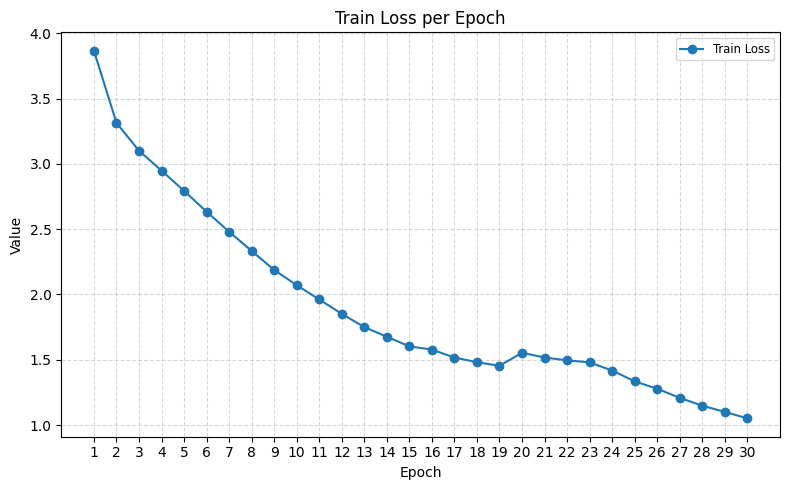

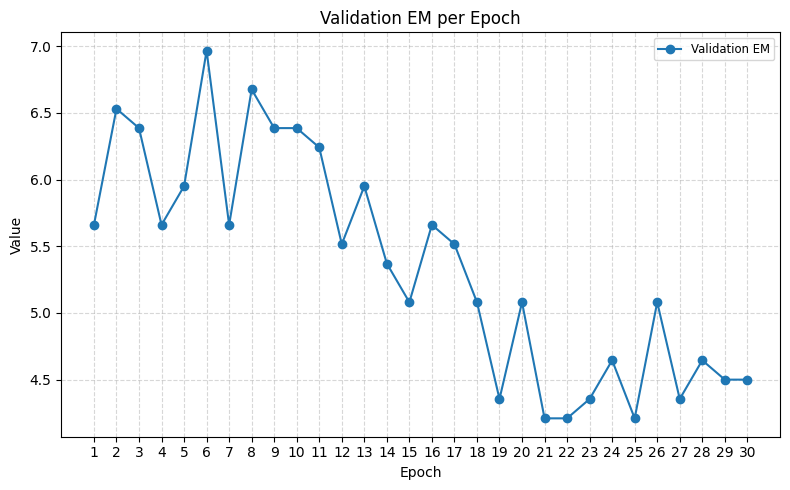

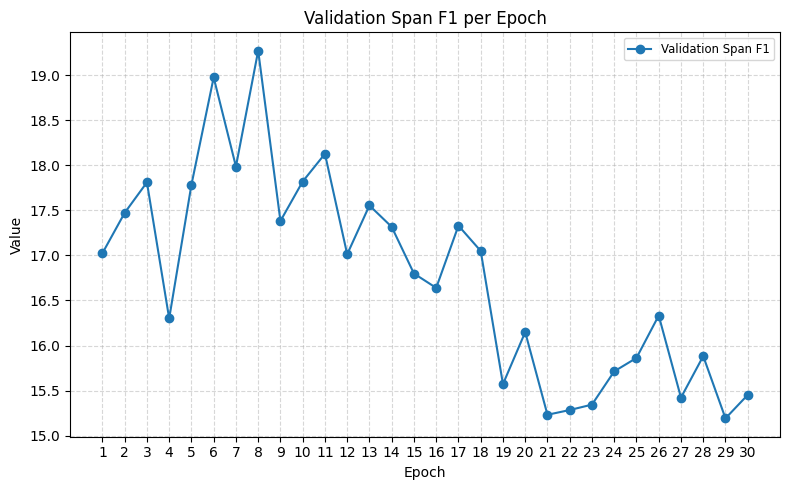

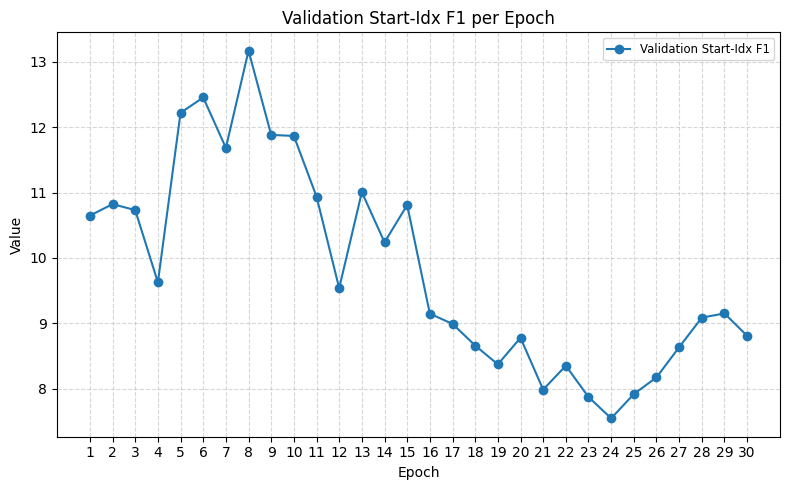

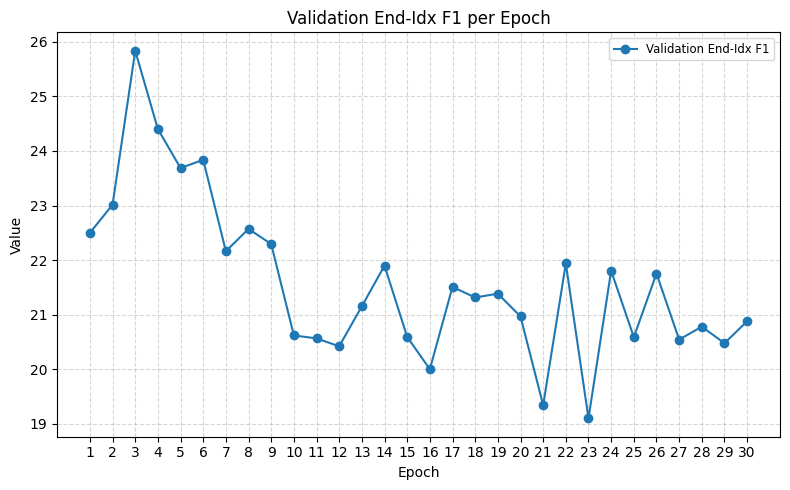

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to your metrics CSV file
csv_path = 'out/eval_summary.csv'  # change this if your file is elsewhere

# Verify the CSV exists
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"Could not find '{csv_path}'. Please check the path.")

# Load metrics
metrics = pd.read_csv(csv_path)

# Metric names and titles
metric_columns = {
    'train_loss': 'Train Loss',
    'em': 'Validation EM',
    'f1': 'Validation Span F1',
    'start_f1': 'Validation Start-Idx F1',
    'end_f1': 'Validation End-Idx F1'
}

# Plot each metric separately
for col, title in metric_columns.items():
    plt.figure(figsize=(8, 5))
    plt.plot(metrics['epoch'], metrics[col], marker='o', label=title, color='tab:blue')

    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'{title} per Epoch')
    plt.xticks(metrics['epoch'])
    plt.legend(loc='best', fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
